In [1]:
#import required packages / set parameters
import pandas as pd
from graph_tool.all import *; import graph_tool.all as gt
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from sklearn import preprocessing
import umap.plot

from matplotlib.colors import ListedColormap
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", rc=custom_params)

pal = sns.color_palette('Set2')
pal.as_hex()

dxcolors = list(map(mpl.colors.rgb2hex, pal))[:4]

order = [1, 2, 0, 3]
dxcolors = [dxcolors[i] for i in order]

path='/media/Data1/tumour_genetics_git/'

In [2]:
#wrangling to curate your dataset
df=pd.read_csv(path+'preproc_df_orig_data.csv',index_col=0)
idx=1

raw = pd.read_excel(path+'histopath_anonymisedlocalcopy_lockedcopy_droppedfew.xlsx')
raw['Age'].replace(["No Age"],None,inplace=True)
raw['Age'].fillna(raw.Age.median(),inplace=True)
age = raw['Age']
del raw
df.insert(loc=idx,column='Age',value=age)
df = df[df.columns.drop(list(df.filter(regex='copy')))]

df_edges=df.copy()
df_edges.drop(df_edges.iloc[:, :22],inplace=True,axis=1)
df_edges = df_edges[df_edges.columns.drop(list(df_edges.filter(regex='copy')))]
df_edges = df_edges[df_edges.columns.drop(list(df_edges.filter(regex='failed')))]
df_edges.head()

orig = pd.read_excel(path+'histopath_anonymisedlocalcopy_lockedcopy_droppedfew.xlsx')
orig['Integr Diag'].replace(['GBM-IDH-wt definite'],'IDH-wt GBM',inplace=True)
orig['Integr Diag'].replace(['Glioma IDHmut NOS','Astrocytoma IDHmut definite'],'IDH-mut Astrocytoma',inplace=True)
orig['Integr Diag'].replace(['GBM-IDH-wt likely'],'IDH-wt GBM',inplace=True)
orig['Integr Diag'].replace(['Oligodendroglioma likely'],'IDH-mut Oligodendroglioma',inplace=True)
orig['Integr Diag'].replace(['Oligodendroglioma definite'],'IDH-mut Oligodendroglioma',inplace=True)
orig['Integr Diag'].replace(['BRAF Fusion Glioma'],"Other Glioma",inplace=True)
orig['Integr Diag'].replace(['BRAF-Glioma'],"Other Glioma",inplace=True)
orig['Integr Diag'].replace(['GBM K27M'],"IDH-wt GBM",inplace=True)
orig['Integr Diag'].replace(['GBM G34R/V'],"IDH-wt GBM",inplace=True)

orig.head()
orig=orig.iloc[:,:5].drop(['Unnamed: 0','request (panel)','Gender'], axis=1)
orig['Diagnosis Known']=1
orig.loc[orig['Integr Diag'].isnull(),'Diagnosis Known']=0
orig['Integr Diag'].replace([None],'Unknown',inplace=True)

df['Integr Diag']=orig['Integr Diag']
df['Diagnosis Known']=orig['Diagnosis Known']
df['Integr Diag_numerical']=df['Integr Diag']

df['Integr Diag_numerical'].replace(['Unknown'],4,inplace=True)
df['Integr Diag_numerical'].replace(['IDH-wt GBM'],0,inplace=True)
df['Integr Diag_numerical'].replace(['IDH-mut Astrocytoma'],1,inplace=True)
df['Integr Diag_numerical'].replace(['IDH-mut Oligodendroglioma'],2,inplace=True)
df['Integr Diag_numerical'].replace(['Other Glioma'],3,inplace=True)

df_edges.shape
df_edges['diagnoses']=df['Integr Diag']
df_edges=df_edges[df_edges['diagnoses']!='Unknown']
df_edges.reset_index(drop=True,inplace=True)

fit = umap.UMAP()
u = fit.fit_transform(df_edges.iloc[:,:-1])
pd.DataFrame(fit.embedding_).shape
diagnoses = df_edges['diagnoses']
diagnoses_df = pd.DataFrame(diagnoses)
diagnoses_df['UMAP 1'] = fit.embedding_[:, 0]
diagnoses_df['UMAP 2'] = fit.embedding_[:, 1]
diagnoses_df['CoPath No (Blue=Dupl)']=df['CoPath No (Blue=Dupl)']

diagnoses_df['IDH nt/failed']=df['IDH nt/failed']
diagnoses_df['ATRX nt/failed']=df['ATRX nt/failed']
diagnoses_df['TERT nt/failed']=df['TERT nt/failed']
diagnoses_df['Hist nt/failed']=df['Hist nt/failed']
diagnoses_df['BRAF point nt/failed']=df['BRAF point nt/failed']
diagnoses_df['EGFR nt/failed']=df['EGFR nt/failed']
diagnoses_df['MGMT nt/failed']=df['MGMT nt/failed']
diagnoses_df['anything_missing_sum']=diagnoses_df['IDH nt/failed']+diagnoses_df['ATRX nt/failed']+diagnoses_df['TERT nt/failed']+diagnoses_df['Hist nt/failed']+diagnoses_df['BRAF point nt/failed']+diagnoses_df['EGFR nt/failed']+diagnoses_df['MGMT nt/failed']
diagnoses_df['anything_missing_bool']=diagnoses_df['anything_missing_sum']
diagnoses_df['anything_missing_bool']=diagnoses_df['anything_missing_bool']/diagnoses_df['anything_missing_bool']
diagnoses_df=diagnoses_df.fillna(0)

In [3]:
print("Patient diagnoses in dataset")
diagnoses_df['diagnoses'].value_counts()

Patient diagnoses in dataset


IDH-mut Astrocytoma          1045
IDH-mut Oligodendroglioma     608
IDH-wt GBM                    571
Other Glioma                  195
Name: diagnoses, dtype: int64

In [4]:
print("Importing survival dataset")

patient_sbm_merged=pd.read_csv(path+'patient_sbm_merged.csv',index_col=0)
patient_sbm_merged=patient_sbm_merged[['CoPath No (Blue=Dupl)','T']]

def clamp_my_data(data,percentile=1):
    perc_lower = np.nanpercentile(data, percentile)
    perc_upper = np.nanpercentile(data, 100-percentile)
    filtered_mx = np.clip(data, a_min=perc_lower, a_max=perc_upper)
    return filtered_mx

patient_sbm_merged['T']=clamp_my_data(patient_sbm_merged['T'],percentile=5)
df=df[df['Diagnosis Known']!=0]
df.reset_index(drop=True,inplace=True)

Importing survival dataset


In [5]:
print("example column structure for patient nodes")
print(df.columns)

example column structure for patient nodes
Index(['CoPath No (Blue=Dupl)', 'Age', 'Male', 'Female',
       'Glioblastoma, IDH-wildtype', 'Other Glioma',
       'Oligodendroglioma, IDH-mutant, and 1p/19q-codeleted',
       'Astrocytoma, IDH-mutant', 'Glioblastoma, IDH-wildtype definite',
       'Astrocytoma, IDH-mutant definite', 'Glioblastoma, IDH-wildtype likely',
       'Oligodendroglioma, IDH-mutant, and 1p/19q-codeleted likely',
       'Oligodendroglioma, IDH-mutant, and 1p/19q-codeleted definite',
       'BRAF Fusion Glioma', 'BRAF-Glioma', 'GBM K27M', 'GBM G34R/V',
       'Age 0-20', 'Age 21-40', 'Age 41-60', 'Age 61-80', 'Age 81-100',
       'IDH wt', 'IDH mut', 'IDH nt/failed', 'IDH1 wt', 'IDH1 mut',
       'IDH1 nt/failed', 'IDH1 G395A', 'IDH1 C394T', 'IDH1 C394G',
       'IDH1 C394A', 'IDH1 G395T', 'IDH1 G394T', 'IDH2 wt', 'IDH2 mut',
       'IDH2 nt/failed', 'IDH2 G515A', 'IDH2 A514T', 'IDH2 A514G',
       'IDH2 G515T', 'ATRX loss', 'ATRX retained', 'ATRX nt/failed', 'TERT w

In [6]:
g = Graph(directed=False)

###prime features
ID = g.new_vertex_property("string")
age=g.new_vertex_property("double")
male=g.new_vertex_property("int")
female=g.new_vertex_property("int")
diag = g.new_vertex_property("string")
diag_numerical = g.new_vertex_property("int")
diag_known = g.new_vertex_property("int")
idh_wt_gbm=g.new_vertex_property("int")
other_glioma=g.new_vertex_property("int")
idh_mut_oligodendroglioma=g.new_vertex_property("int")
idh_mut_astrocytoma=g.new_vertex_property("int")
braf_fusion_glioma=g.new_vertex_property("int")
braf_glioma=g.new_vertex_property("int")
gbm_k27m=g.new_vertex_property("int")
gbm_g34rv=g.new_vertex_property("int")
age_0to20=g.new_vertex_property("int")
age_21to40=g.new_vertex_property("int")
age_41to60=g.new_vertex_property("int")
age_61to80=g.new_vertex_property("int")
age_81to100=g.new_vertex_property("int")
idh_wt=g.new_vertex_property("int")
idh_mut=g.new_vertex_property("int")
idh1_wt=g.new_vertex_property("int")
idh1_mut=g.new_vertex_property("int")
idh1_g395a=g.new_vertex_property("int")
idh1_c394t=g.new_vertex_property("int")
idh1_c394g=g.new_vertex_property("int")
idh1_c394a=g.new_vertex_property("int")
idh1_g395t=g.new_vertex_property("int")
idh1_g394t=g.new_vertex_property("int")
idh2_wt=g.new_vertex_property("int")
idh2_mut=g.new_vertex_property("int")
idh2_g515a=g.new_vertex_property("int")
idh2_a415t=g.new_vertex_property("int")
idh2_a514g=g.new_vertex_property("int")
idh2_g515t=g.new_vertex_property("int")
atrx_loss=g.new_vertex_property("int")
atrx_retained=g.new_vertex_property("int")
tert_wt=g.new_vertex_property("int")
tert_mut=g.new_vertex_property("int")
tert_c228t=g.new_vertex_property("int")
tert_c250t=g.new_vertex_property("int")
hist_wt=g.new_vertex_property("int")
hist_mut=g.new_vertex_property("int")
hist_k27m=g.new_vertex_property("int")
hist_g34r=g.new_vertex_property("int")
braf_wt=g.new_vertex_property("int")
braf_point_mut=g.new_vertex_property("int")
braf_1799ta=g.new_vertex_property("int")
braf_frameshift=g.new_vertex_property("int")
braf_fusion=g.new_vertex_property("int")
braf_exon16_9=g.new_vertex_property("int")
braf_exon15_9=g.new_vertex_property("int")
braf_exon_16_11=g.new_vertex_property("int")
no_egfr_amp=g.new_vertex_property("int")
egfr_amp=g.new_vertex_property("int")
egfr_lowamp=g.new_vertex_property("int")
egfr_modamp=g.new_vertex_property("int")
egfr_highamp=g.new_vertex_property("int")
onep19q_wt=g.new_vertex_property("int")
loh_onep19q=g.new_vertex_property("int")
onep19q_loh=g.new_vertex_property("int")
nineteen_loh=g.new_vertex_property("int")
mgmt_unmeth=g.new_vertex_property("int")
mgmt_meth=g.new_vertex_property("int")
mgmt_0to5=g.new_vertex_property("int")
mgmt_5to10=g.new_vertex_property("int")
mgmt_10to25=g.new_vertex_property("int")
mgmg_gt25=g.new_vertex_property("int")

for vertexnumber, row in df.iterrows():
    node = g.add_vertex()
    
    ###loop prime features
    ID_loop=(row['CoPath No (Blue=Dupl)'])
    age_loop=(row['Age'])
    male_loop=(row['Male'])
    female_loop=(row['Female'])
    diag_loop = (row['Integr Diag'])
    diag_numerical_loop = (row['Integr Diag_numerical'])
    diag_known_loop = (row['Diagnosis Known'])
    gbm_loop=(row['Glioblastoma, IDH-wildtype'])
    other_glioma_loop=(row['Other Glioma'])
    idh_mut_oligodendroglioma_loop=(row['Oligodendroglioma, IDH-mutant, and 1p/19q-codeleted'])
    idh_mut_astrocytoma_loop=(row['Astrocytoma, IDH-mutant'])
    braf_fusion_glioma_loop=(row['BRAF Fusion Glioma'])
    braf_glioma_loop=(row['BRAF-Glioma'])
    gbm_k27m_loop=(row['GBM K27M'])
    gbm_g34rv_loop=(row['GBM G34R/V'])
    age_0to20_loop=(row['Age 0-20'])
    age_21to40_loop=(row['Age 21-40'])
    age_41to60_loop=(row['Age 41-60'])
    age_61to80_loop=(row['Age 61-80'])
    age_81to100_loop=(row['Age 81-100'])
    idh_wt_loop=(row['IDH wt'])
    idh_mut_loop=(row['IDH mut'])
    idh1_wt_loop=(row['IDH1 wt'])
    idh1_mut_loop=(row['IDH1 mut'])
    idh1_g395a_loop=(row['IDH1 G395A'])
    idh1_c394t_loop=(row['IDH1 C394T'])
    idh1_c394g_loop=(row['IDH1 C394G'])
    idh1_c394a_loop=(row['IDH1 C394A'])
    idh1_g395t_loop=(row['IDH1 G395T'])
    idh1_g394t_loop=(row['IDH1 G394T'])
    idh2_wt_loop=(row['IDH2 wt'])
    idh2_mut_loop=(row['IDH2 mut'])
    idh2_g515a_loop=(row['IDH2 G515A'])
    idh2_a415t_loop=(row['IDH2 A514T'])
    idh2_a514g_loop=(row['IDH2 A514G'])
    idh2_g515t_loop=(row['IDH2 G515T'])
    atrx_loss_loop=(row['ATRX loss'])
    atrx_retained_loop=(row['ATRX retained'])
    tert_wt_loop=(row['TERT wt'])
    tert_mut_loop=(row['TERT mut'])
    tert_c228t_loop=(row['TERT C228T'])
    tert_c250t_loop=(row['TERT C250T'])
    hist_wt_loop=(row['Hist wt'])
    hist_mut_loop=(row['Hist mut'])
    hist_k27m_loop=(row['Hist K27M'])
    hist_g34r_loop=(row['Hist G34R'])
    braf_wt_loop=(row['BRAF wt'])
    braf_point_mut_loop=(row['BRAF point mut'])
    braf_1799ta_loop=(row['BRAF 1799 T>A'])
    braf_frameshift_loop=(row['BRAF frameshift'])
    braf_fusion_loop=(row['BRAF fusion'])
    braf_exon16_9_loop=(row['BRAF Exon 16-9'])
    braf_exon15_9_loop=(row['BRAF Exon 15-9'])
    braf_exon_16_11_loop=(row['BRAF Exon 16-11'])
    no_egfr_amp_loop=(row['No EGFR Amp'])
    egfr_amp_loop=(row['EGFR Amp'])
    egfr_lowamp_loop=(row['EGFR low amp'])
    egfr_modamp_loop=(row['EGFR mod amp'])
    egfr_highamp_loop=(row['EGFR high amp'])
    onep19q_wt_loop=(row['1p/19q no co-deletion'])
    loh_onep19q_loop=(row['1p/19q deletion'])
    onep19q_loh_loop=(row['1p/19q co-deletion'])
    nineteen_loh_loop=(row['19q deletion'])
    mgmt_unmeth_loop=(row['MGMT unmethylated'])
    mgmt_meth_loop=(row['MGMT methylated'])
    mgmt_0to5_loop=(row['MGMT 0-5%'])
    mgmt_5to10_loop=(row['MGMT 5-10%'])
    mgmt_10to25_loop=(row['MGMT 10-25%'])
    mgmg_gt25_loop=(row['MGMT >25%'])
    ID[vertexnumber]=ID_loop
    age[vertexnumber]=age_loop
    male[vertexnumber]=male_loop
    female[vertexnumber]=female_loop
    diag[vertexnumber] = diag_loop
    diag_numerical[vertexnumber] = diag_numerical_loop
    diag_known[vertexnumber] = diag_known_loop
    idh_wt_gbm[vertexnumber]=gbm_loop
    other_glioma[vertexnumber]=other_glioma_loop
    idh_mut_oligodendroglioma[vertexnumber]=idh_mut_oligodendroglioma_loop
    idh_mut_astrocytoma[vertexnumber]=idh_mut_astrocytoma_loop
    braf_fusion_glioma[vertexnumber]=braf_fusion_glioma_loop
    braf_glioma[vertexnumber]=braf_glioma_loop
    gbm_k27m[vertexnumber]=gbm_k27m_loop
    gbm_g34rv[vertexnumber]=gbm_g34rv_loop
    age_0to20[vertexnumber]=age_0to20_loop
    age_21to40[vertexnumber]=age_21to40_loop
    age_41to60[vertexnumber]=age_41to60_loop
    age_61to80[vertexnumber]=age_61to80_loop
    age_81to100[vertexnumber]=age_81to100_loop
    idh_wt[vertexnumber]=idh_wt_loop
    idh_mut[vertexnumber]=idh_mut_loop
    idh1_wt[vertexnumber]=idh1_wt_loop
    idh1_mut[vertexnumber]=idh1_mut_loop
    idh1_g395a[vertexnumber]=idh1_g395a_loop
    idh1_c394t[vertexnumber]=idh1_c394t_loop
    idh1_c394g[vertexnumber]=idh1_c394g_loop
    idh1_c394a[vertexnumber]=idh1_c394a_loop
    idh1_g395t[vertexnumber]=idh1_g395t_loop
    idh1_g394t[vertexnumber]=idh1_g394t_loop
    idh2_wt[vertexnumber]=idh2_wt_loop
    idh2_mut[vertexnumber]=idh2_mut_loop
    idh2_g515a[vertexnumber]=idh2_g515a_loop
    idh2_a415t[vertexnumber]=idh2_a415t_loop
    idh2_a514g[vertexnumber]=idh2_a514g_loop
    idh2_g515t[vertexnumber]=idh2_g515t_loop
    atrx_loss[vertexnumber]=atrx_loss_loop
    atrx_retained[vertexnumber]=atrx_retained_loop
    tert_wt[vertexnumber]=tert_wt_loop
    tert_mut[vertexnumber]=tert_mut_loop
    tert_c228t[vertexnumber]=tert_c228t_loop
    tert_c250t[vertexnumber]=tert_c250t_loop
    hist_wt[vertexnumber]=hist_wt_loop
    hist_mut[vertexnumber]=hist_mut_loop
    hist_k27m[vertexnumber]=hist_k27m_loop
    hist_g34r[vertexnumber]=hist_g34r_loop
    braf_wt[vertexnumber]=braf_wt_loop
    braf_point_mut[vertexnumber]=braf_point_mut_loop
    braf_1799ta[vertexnumber]=braf_1799ta_loop
    braf_frameshift[vertexnumber]=braf_frameshift_loop
    braf_fusion[vertexnumber]=braf_fusion_loop
    braf_exon16_9[vertexnumber]=braf_exon16_9_loop
    braf_exon15_9[vertexnumber]=braf_exon15_9_loop
    braf_exon_16_11[vertexnumber]=braf_exon_16_11_loop
    no_egfr_amp[vertexnumber]=no_egfr_amp_loop
    egfr_amp[vertexnumber]=egfr_amp_loop
    egfr_lowamp[vertexnumber]=egfr_lowamp_loop
    egfr_modamp[vertexnumber]=egfr_modamp_loop
    egfr_highamp[vertexnumber]=egfr_highamp_loop
    onep19q_wt[vertexnumber]=onep19q_wt_loop
    loh_onep19q[vertexnumber]=loh_onep19q_loop
    onep19q_loh[vertexnumber]=onep19q_loh_loop
    nineteen_loh[vertexnumber]=nineteen_loh_loop
    mgmt_unmeth[vertexnumber]=mgmt_unmeth_loop
    mgmt_meth[vertexnumber]=mgmt_meth_loop
    mgmt_0to5[vertexnumber]=mgmt_0to5_loop
    mgmt_5to10[vertexnumber]=mgmt_5to10_loop
    mgmt_10to25[vertexnumber]=mgmt_10to25_loop
    mgmg_gt25[vertexnumber]=mgmg_gt25_loop
    
g.vertex_properties["ID"]=ID
g.vertex_properties["age"]=age
g.vertex_properties["male"]=male
g.vertex_properties["female"]=female
g.vertex_properties["diagnosis"]=diag
g.vertex_properties["diagnosis_numerical"]=diag_numerical
g.vertex_properties["diagnosis_known"]=diag_known
g.vertex_properties["idh_wt_gbm"]=idh_wt_gbm
g.vertex_properties["other_glioma"]=other_glioma
g.vertex_properties["idh_mut_oligodendroglioma"]=idh_mut_oligodendroglioma
g.vertex_properties["idh_mut_astrocytoma"]=idh_mut_astrocytoma
g.vertex_properties["braf_fusion_glioma"]=braf_fusion_glioma
g.vertex_properties["braf_glioma"]=braf_glioma
g.vertex_properties["gbm_k27m"]=gbm_k27m
g.vertex_properties["gbm_g34rv"]=gbm_g34rv
g.vertex_properties["age_0to20"]=age_0to20
g.vertex_properties["age_21to40"]=age_21to40
g.vertex_properties["age_41to60"]=age_41to60
g.vertex_properties["age_61to80"]=age_61to80
g.vertex_properties["age_81to100"]=age_81to100
g.vertex_properties["idh_wt"]=idh_wt
g.vertex_properties["idh_mut"]=idh_mut
g.vertex_properties["idh1_wt"]=idh1_wt
g.vertex_properties["idh1_mut"]=idh1_mut
g.vertex_properties["idh1_g395a"]=idh1_g395a
g.vertex_properties["idh1_c394t"]=idh1_c394t
g.vertex_properties["idh1_c394g"]=idh1_c394g
g.vertex_properties["idh1_c394a"]=idh1_c394a
g.vertex_properties["idh1_g395t"]=idh1_g395t
g.vertex_properties["idh1_g394t"]=idh1_g394t
g.vertex_properties["idh2_wt"]=idh2_wt
g.vertex_properties["idh2_mut"]=idh2_mut
g.vertex_properties["idh2_g515a"]=idh2_g515a
g.vertex_properties["idh2_a415t"]=idh2_a415t
g.vertex_properties["idh2_a514g"]=idh2_a514g
g.vertex_properties["idh2_g515t"]=idh2_g515t
g.vertex_properties["atrx_loss"]=atrx_loss
g.vertex_properties["atrx_retained"]=atrx_retained
g.vertex_properties["tert_wt"]=tert_wt
g.vertex_properties["tert_mut"]=tert_mut
g.vertex_properties["tert_c228t"]=tert_c228t
g.vertex_properties["tert_c250t"]=tert_c250t
g.vertex_properties["hist_wt"]=hist_wt
g.vertex_properties["hist_mut"]=hist_mut
g.vertex_properties["hist_k27m"]=hist_k27m
g.vertex_properties["hist_g34r"]=hist_g34r
g.vertex_properties["braf_wt"]=braf_wt
g.vertex_properties["braf_point_mut"]=braf_point_mut
g.vertex_properties["braf_1799ta"]=braf_1799ta
g.vertex_properties["braf_frameshift"]=braf_frameshift
g.vertex_properties["braf_fusion"]=braf_fusion
g.vertex_properties["braf_exon16_9"]=braf_exon16_9
g.vertex_properties["braf_exon15_9"]=braf_exon15_9
g.vertex_properties["braf_exon_16_11"]=braf_exon_16_11
g.vertex_properties["no_egfr_amp"]=no_egfr_amp
g.vertex_properties["egfr_amp"]=egfr_amp
g.vertex_properties["egfr_lowamp"]=egfr_lowamp
g.vertex_properties["egfr_modamp"]=egfr_modamp
g.vertex_properties["egfr_highamp"]=egfr_highamp
g.vertex_properties["onep19q_no_codeletion"]=onep19q_wt
g.vertex_properties["onep19q_deletion"]=loh_onep19q
g.vertex_properties["onep19q_co-deletion"]=onep19q_loh
g.vertex_properties["nineteen_deletion"]=nineteen_loh
g.vertex_properties["mgmt_unmeth"]=mgmt_unmeth
g.vertex_properties["mgmt_meth"]=mgmt_meth
g.vertex_properties["mgmt_0to5"]=mgmt_0to5
g.vertex_properties["mgmt_5to10"]=mgmt_5to10
g.vertex_properties["mgmt_10to25"]=mgmt_10to25
g.vertex_properties["mgmg_gt25"]=mgmg_gt25

edgelist = np.array(np.ones((len(df), len(df))))
idx_indi=edgelist.nonzero()
g.add_edge_list(np.transpose(idx_indi))

print(g)
#we now have a fully connected graph, though currently has parallel edges we will account for later..

<Graph object, undirected, with 2419 vertices and 5851561 edges, 69 internal vertex properties, at 0x7f570e8d7a00>


In [7]:
g.set_vertex_filter(None)

vertex_filter = g.new_vertex_property("bool") 
for v in g.vertices(): 
        if g.vp.diagnosis_known[v] ==1:
            vertex_filter[v] = True 
        else: 
            vertex_filter[v] = False 
g.vertex_properties["diagnosis_filter"]=vertex_filter

g.set_vertex_filter(g.vp.diagnosis_filter)
print(g)

g.set_vertex_filter(None)
print(g)

<Graph object, undirected, with 2419 vertices and 5851561 edges, 70 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8f190>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d6f580>, False), at 0x7f570e8d7a00>
<Graph object, undirected, with 2419 vertices and 5851561 edges, 70 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8f190>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8fac0>, False), at 0x7f570e8d7a00>


In [8]:
weights_eu = euclidean_distances(u)
min_max_scaler = preprocessing.MinMaxScaler()
normalized_weights = 1-(min_max_scaler.fit_transform(weights_eu))

weights = normalized_weights[idx_indi]
ew = g.new_edge_property("double")
ew.a = weights 
g.ep['umap_weight'] = ew

iu= np.triu_indices(normalized_weights.shape[1])
triangle=normalized_weights[iu]
triangle.shape

(2926990,)

Text(0.5, 1.0, 'Euclidean weight distribution')

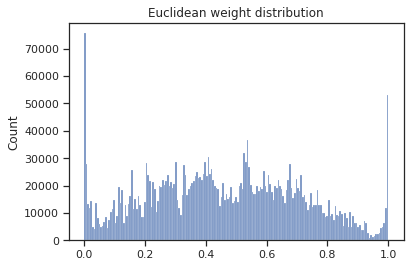

In [9]:
sns.histplot(triangle)
plt.title("Euclidean weight distribution")

In [10]:
print("Example edge list configuration below")
df_edges.drop(['diagnoses'],axis=1,inplace=True)
df_edges.head()

Example edge list configuration below


,IDH wt,IDH mut,IDH1 wt,IDH1 mut,IDH1 G395A,IDH1 C394T,IDH1 C394G,IDH1 C394A,IDH1 G395T,IDH1 G394T,...,1p/19q no co-deletion,1p/19q deletion,1p/19q co-deletion,19q deletion,MGMT unmethylated,MGMT methylated,MGMT 0-5%,MGMT 5-10%,MGMT 10-25%,MGMT >25%
0,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
2,0,1,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [11]:
totalmatrix = np.zeros(normalized_weights.shape)

for label, content in df_edges.items():
    print(label)
    euclidean_data = np.array(1-euclidean_distances(pd.DataFrame(content)))
    
    totalmatrix+=euclidean_data

    weights = euclidean_data[idx_indi]
    ew = g.new_edge_property("int")
    ew.a = weights 
    g.ep[str(label)] = ew
    
weights = totalmatrix[idx_indi]
ew = g.new_edge_property("int")
ew.a = weights 
g.ep['summed_edges'] = ew
    
print("High dimensional edge list computed")
print(g)

IDH wt
IDH mut
IDH1 wt
IDH1 mut
IDH1 G395A
IDH1 C394T
IDH1 C394G
IDH1 C394A
IDH1 G395T
IDH1 G394T
IDH2 wt
IDH2 mut
IDH2 G515A
IDH2 A514T
IDH2 A514G
IDH2 G515T
ATRX loss
ATRX retained
TERT wt
TERT mut
TERT C228T
TERT C250T
Hist wt
Hist mut
Hist K27M
Hist G34R
BRAF wt
BRAF mut
BRAF point mut
BRAF 1799 T>A
BRAF frameshift
BRAF fusion
BRAF Exon 16-9
BRAF Exon 15-9
BRAF Exon 16-11
No EGFR Amp
EGFR Amp
EGFR low amp
EGFR mod amp
EGFR high amp
1p/19q no co-deletion
1p/19q deletion
1p/19q co-deletion
19q deletion
MGMT unmethylated
MGMT methylated
MGMT 0-5%
MGMT 5-10%
MGMT 10-25%
MGMT >25%
High dimensional edge list computed
<Graph object, undirected, with 2419 vertices and 5851561 edges, 70 internal vertex properties, 52 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8f190>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8fac0>, False), at 0x

In [12]:
gt.remove_parallel_edges(g)
gt.remove_self_loops(g)
print(g)

<Graph object, undirected, with 2419 vertices and 2924571 edges, 70 internal vertex properties, 52 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8f190>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f5716d8fac0>, False), at 0x7f570e8d7a00>


In [13]:
g.set_edge_filter(None)

pr = gt.pagerank(g,weight=g.ep.umap_weight)
g.vertex_properties["pr_umap"]=pr

ee_eigen,x_eigen = gt.eigenvector(g,weight=g.ep.umap_weight)
g.vertex_properties["x_eigen_umap"]=x_eigen

vp_between, ep_between = gt.betweenness(g,weight=g.ep.umap_weight)
g.vertex_properties["vp_betwee_umap"]=vp_between
g.edge_properties["ep_between_umap"]=ep_between

c = gt.closeness(g,weight=g.ep.umap_weight)
g.vertex_properties["c_umap"]=c

ee_hits, authority_hits, hub_hits = gt.hits(g,weight=g.ep.umap_weight)
g.vertex_properties["authority_hits_umap"]=authority_hits
g.vertex_properties["hub_hits_umap"]=hub_hits

tree = gt.min_spanning_tree(g,weights=g.ep.umap_weight)
g.ep["minspanningtree_umap"] = tree

tree = gt.min_spanning_tree(g,weights=g.ep.umap_weight)
g.ep["minspanningtree_betweenness_umap"] = tree

pos_sfdp = gt.sfdp_layout(g,eweight=g.ep.ep_between_umap,vweight=g.vp.x_eigen_umap)
pos_sfdp2 = gt.sfdp_layout(g,eweight=g.ep.umap_weight)
pos_sfdp3 = gt.sfdp_layout(g,eweight=g.ep.umap_weight,vweight=g.vp.x_eigen_umap)
                           
g.vp["pos_sfdp_umap"] = pos_sfdp
g.vp["pos_sfd2_umap"] = pos_sfdp2
g.vp["pos_sfd3_umap"] = pos_sfdp3

In [14]:
g.set_edge_filter(None)

pr = gt.pagerank(g,weight=g.ep.summed_edges)
g.vertex_properties["pr_summed_edges"]=pr

ee_eigen,x_eigen = gt.eigenvector(g,weight=g.ep.summed_edges)
g.vertex_properties["x_eigen_summed_edges"]=x_eigen

vp_between, ep_between = gt.betweenness(g,weight=g.ep.summed_edges)
g.vertex_properties["vp_betwee_summed_edges"]=vp_between
g.edge_properties["ep_between_summed_edges"]=ep_between

c = gt.closeness(g,weight=g.ep.summed_edges)
g.vertex_properties["c_summed_edges"]=c

ee_hits, authority_hits, hub_hits = gt.hits(g,weight=g.ep.summed_edges)
g.vertex_properties["authority_hits_summed_edges"]=authority_hits
g.vertex_properties["hub_hits_summed_edges"]=hub_hits

tree = gt.min_spanning_tree(g,weights=g.ep.summed_edges)
g.ep["minspanningtree_summed_edges"] = tree

tree = gt.min_spanning_tree(g,weights=g.ep.summed_edges)
g.ep["minspanningtree_betweenness_summed_edges"] = tree

pos_sfdp = gt.sfdp_layout(g,eweight=g.ep.ep_between_summed_edges,vweight=g.vp.x_eigen_summed_edges)
pos_sfdp2 = gt.sfdp_layout(g,eweight=g.ep.summed_edges)
pos_sfdp3 = gt.sfdp_layout(g,eweight=g.ep.summed_edges,vweight=g.vp.x_eigen_summed_edges)
                           
g.vp["pos_sfdp_summed_edges"] = pos_sfdp
g.vp["pos_sfd2_summed_edges"] = pos_sfdp2
g.vp["pos_sfd3_summed_edges"] = pos_sfdp3

In [15]:
g.set_edge_filter(None)
g.set_vertex_filter(None)
print(g)
g.save(path+"patient_graph_model.xml.gz")

<Graph object, undirected, with 2419 vertices and 2924571 edges, 88 internal vertex properties, 58 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f570e8c9370>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f570e8c97c0>, False), at 0x7f570e8d7a00>


In [16]:
diagnoses_df['diagnoses'].value_counts()
print("No more saving after this point to ensure no data leaking!")

No more saving after this point to ensure no data leaking!


In [17]:
g.set_vertex_filter(None)
vertex_survival_filter = g.new_vertex_property("bool") 
survival=g.new_vertex_property("int")

for v in g.vertices():    
    s = patient_sbm_merged.loc[patient_sbm_merged['CoPath No (Blue=Dupl)']==g.vp['ID'][v],['T']]['T']
    
    if len(s)==0:
        survival[v]=0
        vertex_survival_filter[v] = False 
        
    if len(s)>0:
        survival[v]=int(s.values[0])
        vertex_survival_filter[v] = True
    
g.vertex_properties["survival"]=survival
g.vertex_properties["survival_filter"]=vertex_survival_filter

g.set_vertex_filter(g.vp.survival_filter)

In [18]:
g.set_edge_filter(None)
g.set_vertex_filter(None)
g.set_vertex_filter(g.vp.diagnosis_filter)
g.purge_vertices()
g.set_vertex_filter(g.vp.survival_filter)
g.purge_vertices()
print(g)

vcmap = ListedColormap(dxcolors)
tree = gt.min_spanning_tree(g,weights=g.ep.summed_edges)
g.ep["minspanningtree_summed_edges_diagnosis_known"] = tree
g.set_edge_filter(g.ep.minspanningtree_summed_edges_diagnosis_known)
pos = gt.sfdp_layout(g,eweight=g.ep.summed_edges)

<Graph object, undirected, with 769 vertices and 295296 edges, 90 internal vertex properties, 58 internal edge properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f570c2fcb50>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f570e8d7a00, at 0x7f570c3fb760>, False), at 0x7f570e8d7a00>


Minimum spanning tree of graph, showing diagnoses


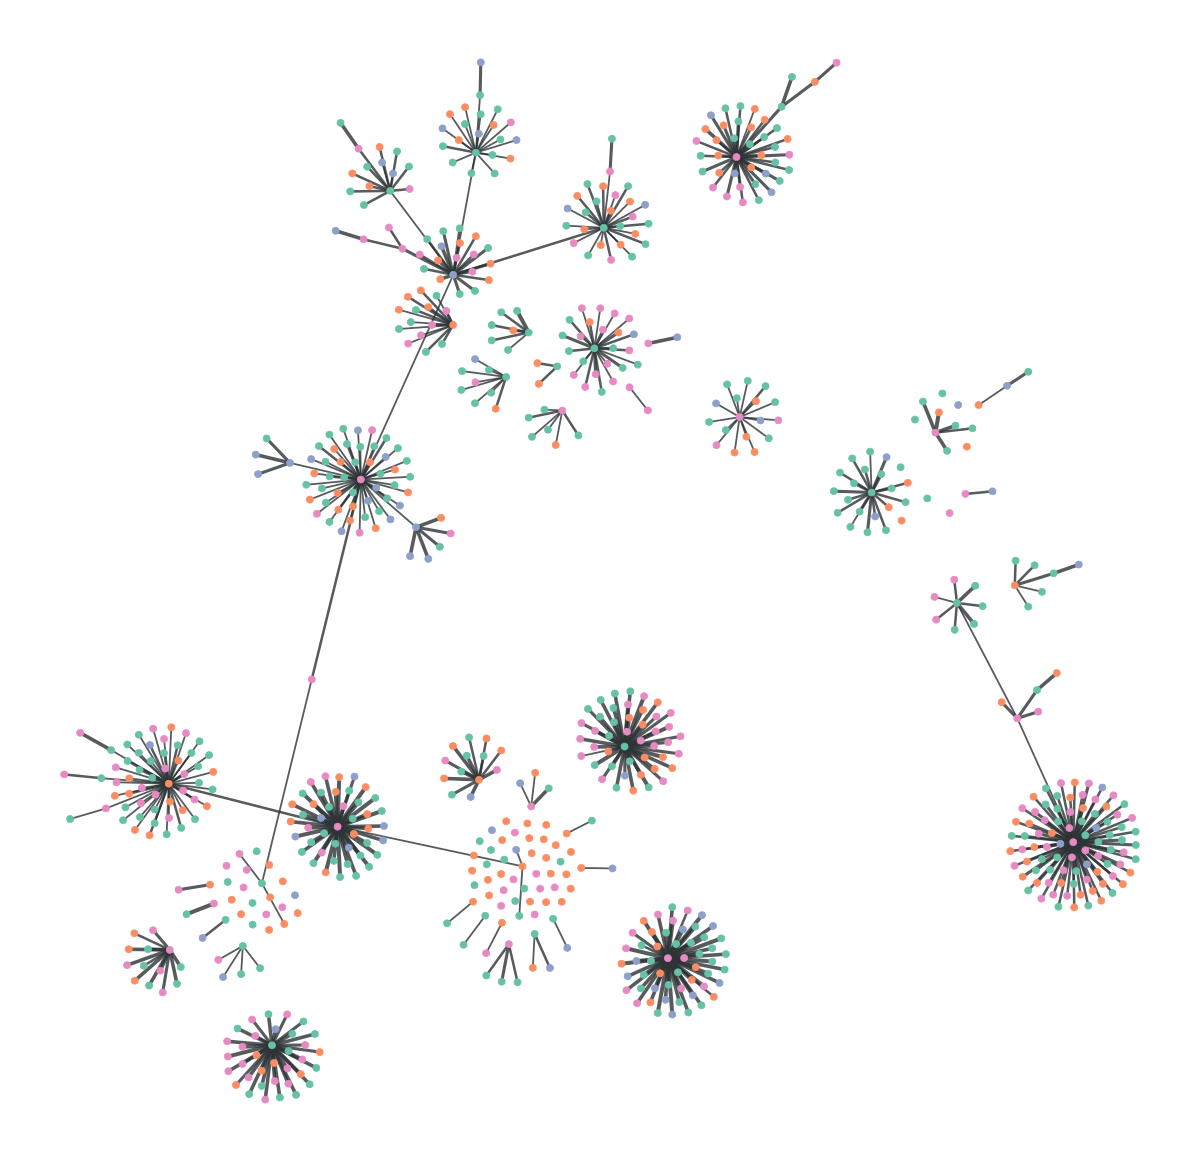

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f570e8d7a00, at 0x7f57169afe50>

In [19]:
print("Minimum spanning tree of graph, showing diagnoses")
gt.graph_draw(g,pos=pos,vertex_fill_color=g.vp.diagnosis_numerical,vertex_color=g.vp.diagnosis_numerical,edge_pen_width=gt.prop_to_size(g.ep.summed_edges,0.01,2),vcmap=vcmap,vertex_size=3.5)

Minimum spanning tree of graph, showing survival


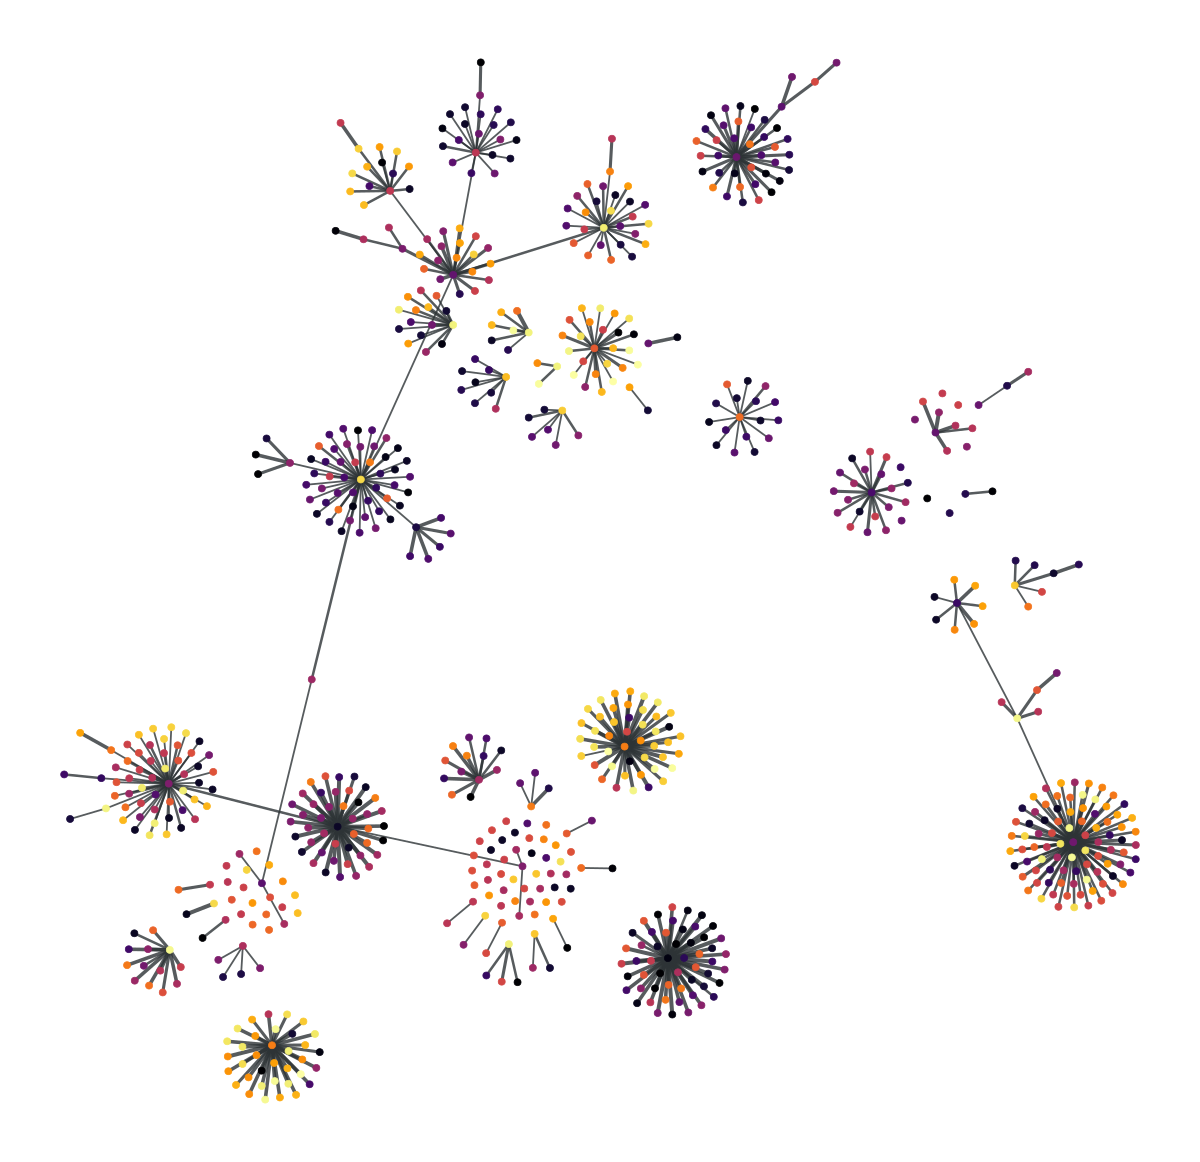

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f570e8d7a00, at 0x7f5716b613d0>

In [20]:
print("Minimum spanning tree of graph, showing survival")
gt.graph_draw(g,pos=pos,vertex_fill_color=g.vp.survival,vertex_color=g.vp.survival,edge_pen_width=gt.prop_to_size(g.ep.summed_edges,0.01,2),vcmap=mpl.cm.inferno,vertex_size=3.5)